Name: Vidhur Busannagari

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import yfinance as yf

Data Preprocessing:
In the below code cell, write your code to load and preprocess the data given to you in the challenge. In the space below this text cell, write any comments you have about your code/reasoning (why you processed the data in a certain way, what you noticed, etc.)

Noticed missing values, NaN, characters inside of a float.

In [26]:
# Part 1: Data Retrieval and Preprocessing
def preprocess_data(file_path):
    """
    Preprocesses the data from the given file path.
    
    Args:
        file_path (str): The path to the CSV file containing the data.
        
    Returns:
        pandas.DataFrame: The preprocessed data as a DataFrame.
    """
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Convert the 'Date' column to datetime format
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Set the 'Date' column as the index of the DataFrame
    data.set_index('Date', inplace=True)
    
    # Remove rows with blank, string, or mixed values by converting to numeric
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Drop rows with missing values
    data = data.dropna()
    
    return data

# Specify the file path of the portfolio data CSV file
file_path = 'fm_challenge_data.csv'

# Preprocess the portfolio data
portfolio_data = preprocess_data(file_path)

# Fetch benchmark data using yfinance
def fetch_benchmark_data(start_date, end_date):
    """
    Fetches benchmark data (S&P 500) for the specified date range using yfinance.
    
    Args:
        start_date (str): The start date of the data range (inclusive).
        end_date (str): The end date of the data range (inclusive).
        
    Returns:
        pandas.Series: The benchmark returns as a Series.
    """
    # Specify the ticker symbol for S&P 500
    benchmark_ticker = '^GSPC'
    
    # Download the benchmark data using yfinance
    benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date)
    
    # Calculate the percentage change of the adjusted closing prices
    benchmark_data = benchmark_data['Adj Close'].pct_change().dropna()
    
    # Set the name of the Series to 'Benchmark_Returns'
    benchmark_data.name = 'Benchmark_Returns'
    
    return benchmark_data

# Get the start and end dates from the portfolio data
start_date = portfolio_data.index.min()
end_date = portfolio_data.index.max()

# Fetch the benchmark returns for the specified date range
benchmark_returns = fetch_benchmark_data(start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


EDA:
In the below code cell, write the code that you used for your EDA. In the space below this text cell, write any comments you have about your code/reasoning (what you checked in your analysis, what you noticed, etc.)

No notable observations

Basic Statistics:
           stock1      stock2      stock3      stock4      stock5      stock6  \
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean    79.261265  248.921075  248.704266   15.741687  196.101941   62.860092   
std     53.022812  142.271190  159.775245    2.263787   87.108564    9.829832   
min     12.690500   56.537937   48.329269   11.392649   72.403496   44.626961   
25%     28.919000  123.331911  104.906380   13.736141  121.777889   54.723558   
50%     80.690750  233.782318  218.061318   15.979893  181.090004   61.840727   
75%    123.845373  368.028840  388.238968   17.327997  239.911232   72.137127   
max    175.353500  538.505737  551.089966   21.086044  427.507721   86.250000   

           stock7      stock8      stock9     stock10  
count  128.000000  128.000000  128.000000  128.000000  
mean   218.168212  112.326866   72.993414  106.258697  
std     80.525211   16.258610   59.332716   29.529924  
min    120.030106   82.18452

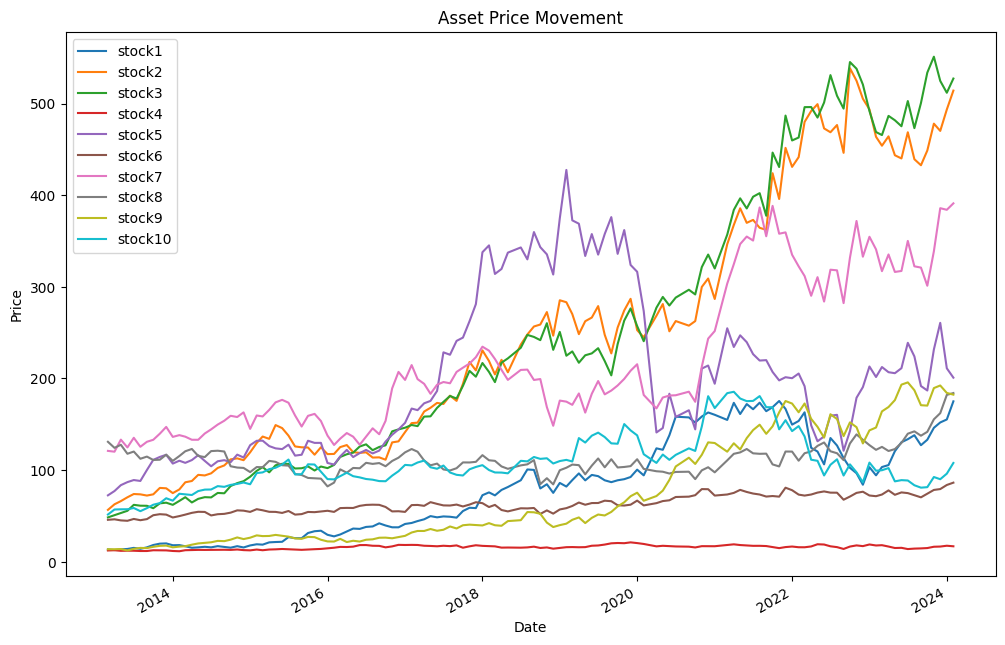

In [27]:
# Part 2: Exploratory Data Analysis (EDA)
def perform_eda(data):
    """
    Performs exploratory data analysis on the given data.
    
    Args:
        data (pandas.DataFrame): The data to analyze.
    """
    # Print basic statistics of the data
    print("Basic Statistics:")
    print(data.describe())
    
    # Print the correlation matrix of the data
    print("\nCorrelation Matrix:")
    print(data.corr())
    
    # Plot the asset price movement
    data.plot(figsize=(12, 8))
    plt.title("Asset Price Movement")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

# Perform EDA on the portfolio data
perform_eda(portfolio_data)

Model Implementation:
In the below code cell, write your code to implement CAPM and then a model of your choosing to generate the weights for each asset. In the space below this text cell, write any comments you have about your code/reasoning (what model you chose and why, etc.)

Used a Mean-Variance Optimization (MVO) model since it is a widely used portfolio optimization technique in finance. Helps find the optimal balance between risk and return based on investment goals and risk tolerance. By considering the correlations between assets and using a quantitative approach, the MVO model allows for the construction of diversified portfolios that minimize overall risk. Although it has some limitations, such as relying on assumptions of normally distributed returns and being sensitive to input parameters.

In [28]:
# Part 3: Model Experimentation
def calculate_returns(data):
    """
    Calculates the returns of the assets in the given data.
    
    Args:
        data (pandas.DataFrame): The data containing asset prices.
        
    Returns:
        pandas.DataFrame: The calculated returns of the assets.
    """
    # Calculate the percentage change of the asset prices
    returns = data.pct_change().dropna()
    return returns

def capm_weights(returns):
    """
    Calculates the optimal weights using the Capital Asset Pricing Model (CAPM).
    
    Args:
        returns (pandas.DataFrame): The returns of the assets.
        
    Returns:
        numpy.ndarray: The optimal weights of the assets.
    """
    # Calculate the market returns as the mean of asset returns
    market_returns = returns.mean()
    
    # Calculate the covariance matrix of asset returns
    cov_matrix = returns.cov()
    
    # Define the portfolio variance function
    def portfolio_variance(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Define the portfolio return function
    def portfolio_return(weights):
        return np.dot(returns.mean(), weights)
    
    # Get the number of assets
    num_assets = len(returns.columns)
    
    # Define the constraints for the optimization
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Define the bounds for the optimization (weights between 0 and 1)
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    # Define the objective function (negative Sharpe ratio)
    def sharpe_ratio_objective(weights):
        return -portfolio_return(weights) / np.sqrt(portfolio_variance(weights))
    
    # Set the initial weights equally distributed among assets
    initial_weights = np.array(num_assets * [1. / num_assets])
    
    # Perform the optimization to find the optimal weights
    optimal_weights = minimize(sharpe_ratio_objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimal_weights.x

# Calculate the returns of the assets
returns = calculate_returns(portfolio_data)

# Calculate the optimal weights using CAPM
capm_optimal_weights = capm_weights(returns)

# Print the CAPM optimal weights
print("CAPM Optimal Weights:")
for i, weight in enumerate(capm_optimal_weights, 1):
    print(f"Asset {i}: {weight:.4f}")

# b. Custom Model (Mean-Variance Optimization)
def portfolio_return(weights, returns):
    """
    Calculates the portfolio return given weights and asset returns.
    
    Args:
        weights (numpy.ndarray): The weights of the assets.
        returns (pandas.DataFrame): The returns of the assets.
        
    Returns:
        float: The portfolio return.
    """
    return np.dot(weights, returns)

def portfolio_variance(weights, cov_matrix):
    """
    Calculates the portfolio variance given weights and covariance matrix.
    
    Args:
        weights (numpy.ndarray): The weights of the assets.
        cov_matrix (pandas.DataFrame): The covariance matrix of asset returns.
        
    Returns:
        float: The portfolio variance.
    """
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def optimize_portfolio_custom(returns, cov_matrix, risk_aversion):
    """
    Optimizes the portfolio using custom mean-variance optimization.
    
    Args:
        returns (pandas.DataFrame): The returns of the assets.
        cov_matrix (pandas.DataFrame): The covariance matrix of asset returns.
        risk_aversion (float): The risk aversion parameter.
        
    Returns:
        numpy.ndarray: The optimal weights of the assets.
    """
    # Get the number of assets
    num_assets = len(returns.columns)
    
    # Define the constraints for the optimization
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Define the bounds for the optimization (weights between 0 and 1)
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    # Define the objective function (negative utility)
    def objective(weights):
        return -portfolio_return(weights, returns.mean()) + risk_aversion * portfolio_variance(weights, cov_matrix)
    
    # Set the initial weights equally distributed among assets
    initial_weights = np.ones(num_assets) / num_assets
    
    # Perform the optimization to find the optimal weights
    result = minimize(objective, x0=initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

# Set the risk aversion parameter
risk_aversion = 1

# Calculate the covariance matrix of asset returns
cov_matrix = returns.cov()

# Calculate the optimal weights using custom mean-variance optimization
custom_weights = optimize_portfolio_custom(returns, cov_matrix, risk_aversion)

# Print the custom model optimal weights
print("\nCustom Model Optimal Weights:")
for i, weight in enumerate(custom_weights, 1):
    print(f"Asset {i}: {weight:.4f}")

CAPM Optimal Weights:
Asset 1: 0.1299
Asset 2: 0.0171
Asset 3: 0.5151
Asset 4: 0.0774
Asset 5: 0.0286
Asset 6: 0.0000
Asset 7: 0.0000
Asset 8: 0.0000
Asset 9: 0.2318
Asset 10: 0.0000

Custom Model Optimal Weights:
Asset 1: 0.3136
Asset 2: 0.0929
Asset 3: 0.2330
Asset 4: 0.0000
Asset 5: 0.0000
Asset 6: 0.0000
Asset 7: 0.0000
Asset 8: 0.0000
Asset 9: 0.3606
Asset 10: 0.0000


Model Backtesting:
In the below code cell, write your code to backtest your model against the benchmark of the S&P 500 and computing your backtesting metrics. In the space below this text cell, write any comments you have about your code/reasoning (what you noticed about the results, etc.)

No Notebale Comments


Backtesting CAPM Model:


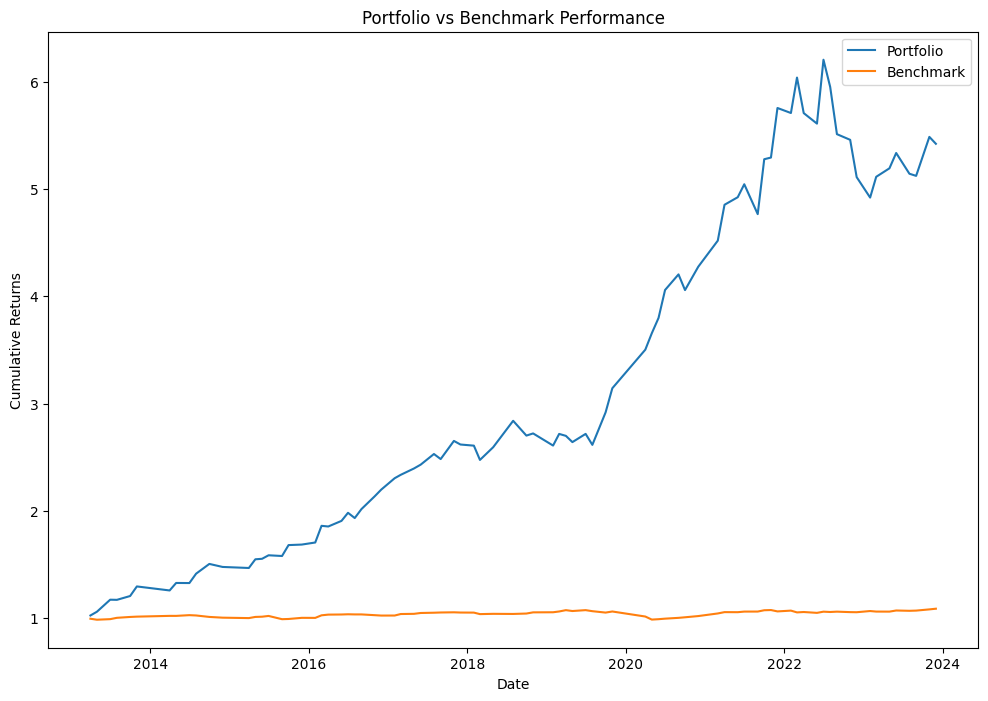

Sharpe Ratio: 7.60
Volatility: 0.72

Backtesting Custom Model:


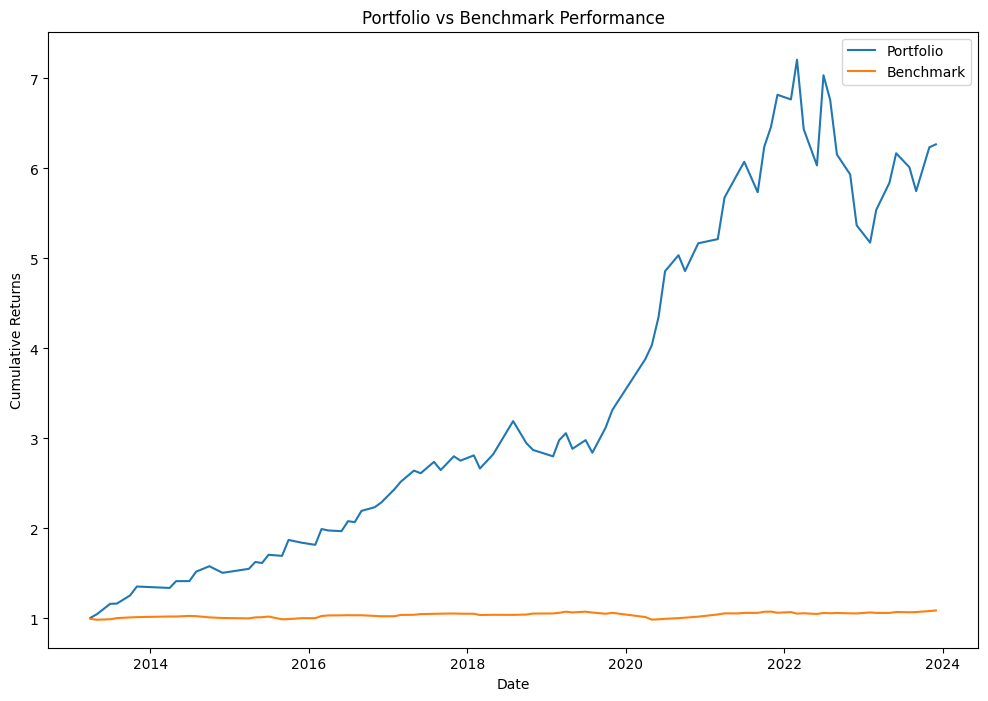

Sharpe Ratio: 6.69
Volatility: 0.91


In [29]:
# Part 4: Backtesting
def backtest_portfolio(returns, weights, benchmark_returns):
    """
    Backtests the portfolio using the given returns, weights, and benchmark returns.

    Args:
        returns (pandas.DataFrame): The returns of the assets.
        weights (numpy.ndarray): The weights of the assets.
        benchmark_returns (pandas.Series): The benchmark returns.
    """
    # Calculate the portfolio returns by multiplying the asset returns with their corresponding weights
    portfolio_returns = pd.Series(np.dot(returns, weights), index=returns.index)
    
    # Concatenate the portfolio returns and benchmark returns into a single DataFrame
    aligned_returns = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
    
    # Set the column names of the aligned returns DataFrame
    aligned_returns.columns = ['Portfolio', 'Benchmark']
    
    # Calculate the cumulative returns of the portfolio and benchmark
    cumulative_returns = (1 + aligned_returns).cumprod()
    
    # Calculate the Sharpe ratio of the portfolio
    sharpe_ratio = np.sqrt(252) * aligned_returns['Portfolio'].mean() / aligned_returns['Portfolio'].std()
    
    # Calculate the volatility of the portfolio
    volatility = aligned_returns['Portfolio'].std() * np.sqrt(252)
    
    # Plot the cumulative returns of the portfolio and benchmark
    plt.figure(figsize=(12, 8))
    plt.plot(cumulative_returns['Portfolio'], label="Portfolio")
    plt.plot(cumulative_returns['Benchmark'], label="Benchmark")
    plt.title("Portfolio vs Benchmark Performance")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.show()
    
    # Print the Sharpe ratio and volatility of the portfolio
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Volatility: {volatility:.2f}")

# Backtest the CAPM model
print("\nBacktesting CAPM Model:")
backtest_portfolio(returns, capm_optimal_weights, benchmark_returns)

# Backtest the custom model
print("\nBacktesting Custom Model:")
backtest_portfolio(returns, custom_weights, benchmark_returns)

References:
In this text cell, please give any references you used (including ChatGPT!), and what you got out of that resource. 

Used GPT for commenting code, getting information about finance terminology, for documentaiton, and for some code